<center><h1>Hotel Market Research Through Analysis of Hotel Reviews<br>
    MSBA327 Text Analytics<br>
    Jake Hutton, Brandon Pak, Evan Uribe</h1></center>

### Problem Statement and Background Information
We provide consulting services to the hospitality industry. A client is interested in developing a nation-wide chain of boutique hotels.  Our initial task is to perform market research by looking at national hotel reviews to determine the common factors that lead to a chain’s success such as: location, amenities, service, consumer demographics, etc.  
McCarthy et. Al (2010), found the most common sources of hotel information for leisure travelers are friends and family recommendation, search engines (Google), travel-related websites, meta-search websites (Expedia, Priceline), and hotel reviews (Tripadvisor, Twitter, blogs) in that order.  Our goal is to increase customer willingness to give positive recommendations and a high review score while also minimizing negative recommendations.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# map the treebank tags to WordNet part of speech names
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# text cleansing
def clean_text(text):
    stop_words = ['hotel','stay','stayed','room','try','take','get','go', 'would',\
                  'one', 'make', 'well', 'back', 'say', 'like'] +  stopwords.words('english')
    
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")] # remove puncutation
    text = [word for word in text if not any(c.isdigit() for c in word)] # remove words with numbers
    text = [x for x in text if x not in stop_words] # remove stop words
    text = [t for t in text if len(t) > 0] # remove empty tokens
     # lemmatize text
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1] # remove words with only one letter
    
    text = " ".join(text)
    return(text)

### Exploratory Data Analysis

In [5]:
reviews = pd.read_csv("~/Documents/workspace/ggu/data/Course Data/Datafiniti_Hotel_Reviews_Jun19.csv")
reviews = reviews.drop(['id', 'address','dateAdded','dateUpdated','categories',
                        'primaryCategories','keys','reviews.dateAdded','reviews.dateSeen', 
                        'reviews.username', 'sourceURLs', 'websites'], axis=1)

print('number of records: ',reviews.shape[0])
print(reviews.isnull().sum() )

# label good vs bad based on reviews.rating (1..5) in a binary field: rating
reviews["rating"] = reviews["reviews.rating"].apply(lambda x: 0 if x <4 else 1)

number of records:  10000
city                    0
country                 0
latitude                0
longitude               0
name                    0
postalCode              0
province                0
reviews.date            0
reviews.rating          0
reviews.sourceURLs      0
reviews.text            0
reviews.title           1
reviews.userCity        0
reviews.userProvince    2
dtype: int64


In [6]:
reviews[['name','city', 'province', 'reviews.text', 'reviews.rating']].head(5)

,name,city,province,reviews.text,reviews.rating
0,Best Western Plus South Coast Inn,Goleta,CA,"This hotel was nice and quiet. Did not know, t...",3
1,Best Western Carmel's Town House Lodge,Carmel by the Sea,CA,We stayed in the king suite with the separatio...,4
2,Best Western Carmel's Town House Lodge,Carmel by the Sea,CA,"Parking was horrible, somebody ran into my ren...",3
3,Best Western Carmel's Town House Lodge,Carmel by the Sea,CA,Not cheap but excellent location. Price is som...,5
4,Best Western Carmel's Town House Lodge,Carmel by the Sea,CA,If you get the room that they advertised on th...,2


10,000 reviews of US hotels from 2003 to 2019 
Data preprocessing
~ fairly clean, with very little missing values
~ text cleansing (case normalization, lemmatization, stop word and punctuation removal )
~ calculated sentiment scores based on VADER (Valence Aware Dictionary and sEntiment Reasoner); attuned to social media, human-curated gold standard sentiment lexicon

count    10000.000000
mean         4.084100
std          1.152371
min          1.000000
25%          4.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: reviews.rating, dtype: float64


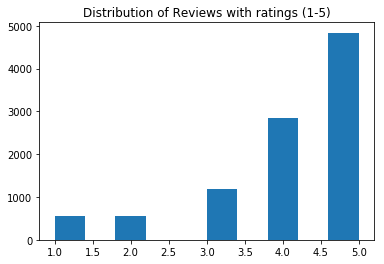

In [7]:
print(reviews['reviews.rating'].describe())

plt.hist(reviews['reviews.rating'])
plt.title('Distribution of Reviews with ratings (1-5)');

There are far many 5 star reviews followed by 4 star reviews.  Star ratings have limitations in terms of sentiment analysis.  Reviewers tend to rate either very high, or very low when there is a numeric scale, so the rating may not be an accurate reflection of sentiment. Another issue is that the wrong rating scale may be applied;  attaching a 5-star rating to bad reviews, or  1-star to positive reviews, or when there are no stars at all.  

A study by ConsumerAffairs in 2016 found that while star ratings are a factor, consumers trust review content over star ratings. It is the quality and sentiment of the review content that drives consumers' brand trust and increases their intent to purchase. 

Given this limitation, we will use NADER rather than the star ratings to assess sentiment. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon, rule-based sentiment analysis tool attuned to social media sentiments. VADER produces 4 sentiment scores from word ratings (positive, neutral, negative, compound). The compound score, is the sum of all of the lexicon ratings, standardized to the range:  -1  (extreme negative) to  +1 (extreme positive).

1    0.7689
0    0.2311
Name: rating, dtype: float64


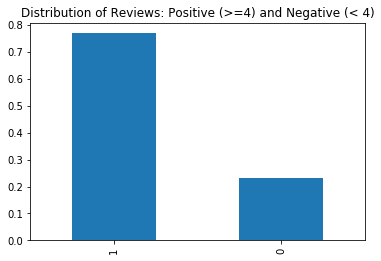

In [8]:
# positive vs negative reviews star counts converted to binary
prob = reviews["rating"].value_counts(normalize = True)
print(prob)
prob.plot(kind='bar')
plt.title('Distribution of Reviews: Positive (>=4) and Negative (< 4)');

Converting ratings into binary: Positive (>=4) and Negative (<4), we have ~ 77% positive and ~23% negative

### Review distributions by hotel

In [9]:
# return dataframe sorted by avg review ratings (star-ratings), grouped by hotel name
def getHotelByRatings (n_reviews, LT = False, colName='rating'):
    
    df = reviews[['name', 'city','province','reviews.userCity', 'reviews.userProvince', colName]] 
    
    # filter to hotels with at least x reviews
    df = df.groupby(['name', colName]).filter(lambda x: x['name'].count()>=5) 

    if not LT:
        hotels = df.groupby(['name', colName]).filter(lambda x: x['name'].count()>=n_reviews) #hotels with more than x reviews
    else:
        hotels = df.groupby(['name', colName]).filter(lambda x: x['name'].count()<=n_reviews).head(n_reviews*20) #limit to 100 hotel chains fo
        

    # get the mean rating by hotel
    d1 = hotels.groupby(['name'])[colName].mean().rename('mean_rating')
    byRatings = pd.concat([d1], axis=1).reset_index()
    byRatings= byRatings.sort_values('mean_rating',ascending=True);
    return byRatings
    

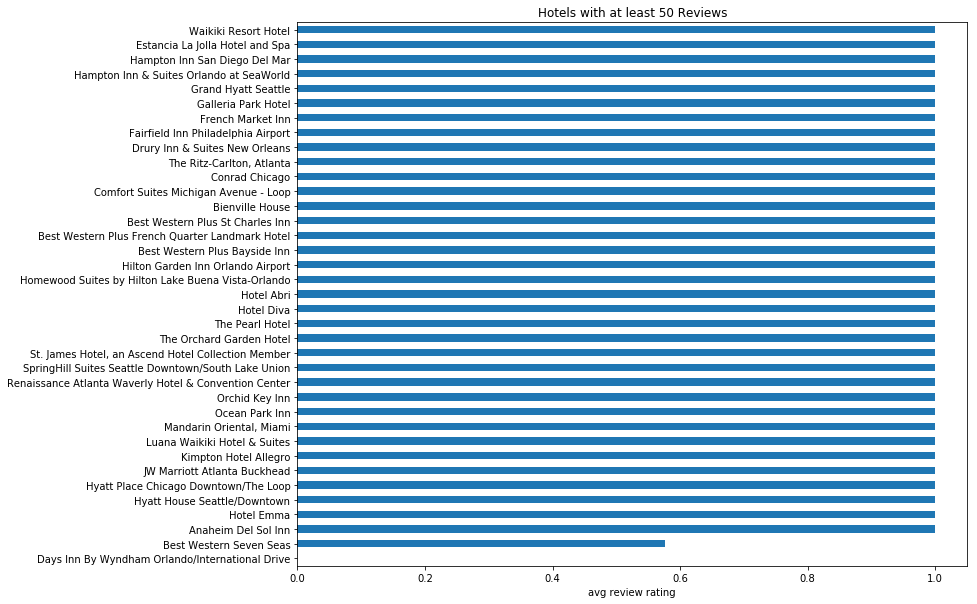

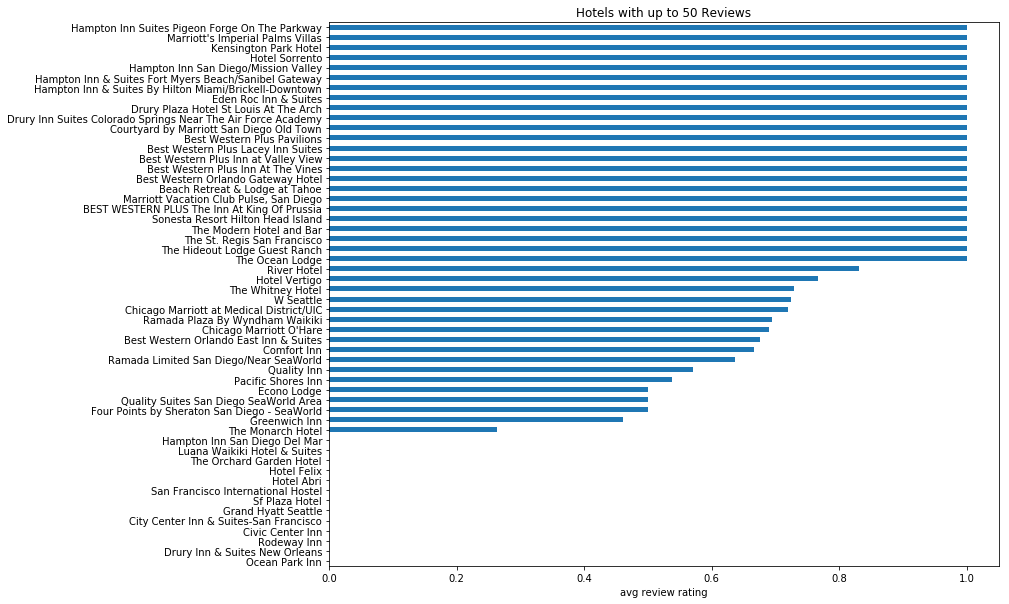

In [10]:
# hotels with at least 50 reviews
df = getHotelByRatings (50)
df.plot(kind='barh',x='name',y='mean_rating', legend=False, figsize=(12,10))
plt.xlabel('avg review rating')
plt.ylabel('')
plt.title('Hotels with at least 50 Reviews');

# hotels with up to 50 reviews
df = getHotelByRatings (50, True).head(600)
df.plot(kind='barh',x='name',y='mean_rating', legend=False, figsize=(12,10))
plt.xlabel('avg review rating')
plt.ylabel('')
plt.title('Hotels with up to 50 Reviews');


It appears that generally,  the more reviews a hotel has (>=50) the more positive the reviews? Let visualize via a scatter plot.

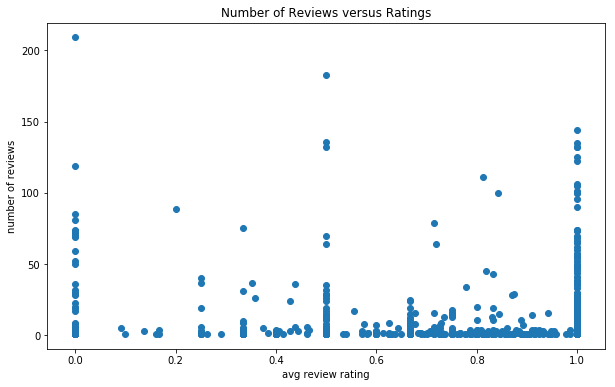

In [11]:
# relationship between number of reviews and ratings
df =  reviews
#df =  reviews.groupby(['name', 'rating']).filter(lambda x: x['name'].count()>=5) # hotels with at least x reviews
rating = df.groupby(['name'])['rating'].mean().reset_index()['rating']
counts = df['name'].value_counts().reset_index()['name']
plt.figure(figsize=(10,6))
plt.scatter(x=rating, y=counts)
plt.xlabel('avg review rating')
plt.ylabel('number of reviews')
plt.title('Number of Reviews versus Ratings');

In [12]:
#pd.concat([counts, rating], axis=1).tail(20)

From the scatter plot, there is no relationship between number of reviews and positive ratings

### Review distributions by state

In [13]:
def plotReviewFreq(cname='province', n=10, e='State', limit=0):
   
    df =  reviews.groupby(['name', 'rating']).filter(lambda x: x['name'].count()>=5) # hotels with at least x reviews
    dfState=None
    if limit==0:
        dfState = df [cname].value_counts()
    else:
        dfState = df [cname].value_counts().head(limit)
        
    dfState.plot(kind='bar',x=cname, legend=False, figsize=(8,5))
    plt.title('Number of Reviews by ' + e);

    # filter by top n states with the highest # of reviews
    topN = df [cname].value_counts().reset_index().iloc[:n]['index'].tolist()
    mylambda = lambda x: x in topN
    topN = df.loc[reviews[cname].apply(mylambda)]
    df = topN.groupby([cname])['rating'].mean().rename('mean_rating')
    #df = df['mean_rating'].apply(np.ceil) # round up

    byRatings = pd.concat([df], axis=1).reset_index()
    byRatings= byRatings.sort_values('mean_rating',ascending=True);

    byRatings.plot(kind='barh',x=cname,y='mean_rating', legend=False, figsize=(8,5))
    plt.xlabel('avg review rating')
    plt.ylabel('')
    plt.title('Reviews for Top '+ str(n) + ' '+ e + '(s)');


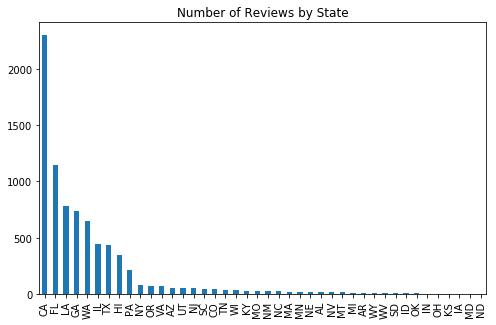

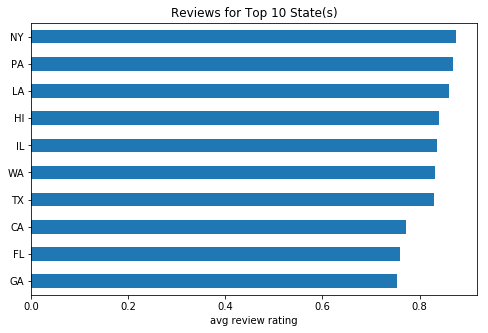

In [14]:
plotReviewFreq()

Here we see that the top 10 States with many reviews includes CA and FL with CA having far more reviews than any other state, which is indicative of the popularity of CA as a destination.  In terms of location, we should consider the development of our boutique hotel within these top states.   

### Review distributions by city

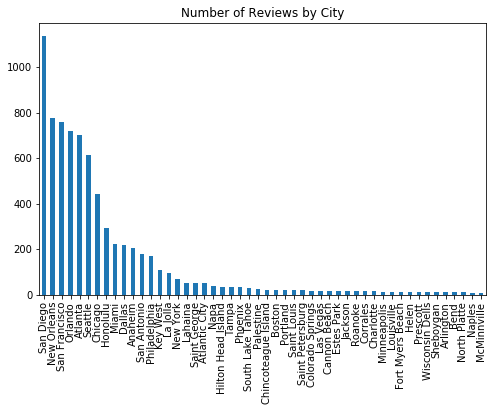

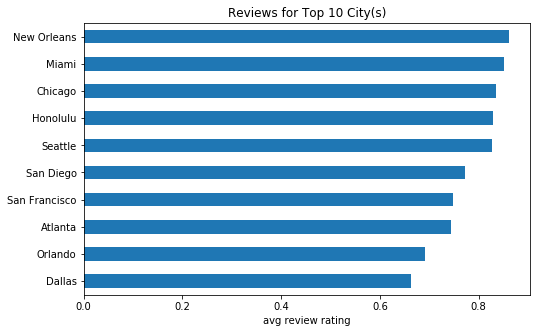

In [15]:
plotReviewFreq(cname='city', e='City', limit=50)

San Diego, New Orleans, San Francisco, Orlando, Atlanta, Seattle appear to be popular destinations given a higher number of reviews.

Of top 10 cities, New Orleans, Miami, Chicago, Honolulu, Seattle have positive (over 80%)

### Sentiment Anaylsis


In [16]:
# add a new df for reviews
reviews2 = reviews[["reviews.text", "rating"]]  

reviews2["review_clean"] = reviews2["reviews.text"].apply(lambda x: clean_text(x)) #field for cleaned text
#reviews2 = reviews2.drop(['reviews.text'], axis=1) # drop original

In [17]:
# add vader sentiment columns as features

from nltk.sentiment.vader import SentimentIntensityAnalyzer 
sa = SentimentIntensityAnalyzer() #Vader sentiment anaylsis

# add polarity_scores: sentiment dictionary containing (pos, neg, neu, and compound scores).
reviews2["sentiments"] = reviews2["review_clean"].apply(lambda x: sa.polarity_scores(x))

# drop sentiment field
reviews2 = pd.concat([reviews2.drop(['sentiments'], axis=1),reviews2['sentiments'].apply(pd.Series)], axis=1)


In [18]:
# Add calculated vader score

# Vader compound score is a metric that calculates the sum of all the lexicon ratings 
# normalized between -1 (most extreme negative) and +1 (most extreme positive).
# positive : (compound >= 0.05)
# neutral : (compound  > -0.05) and (compound < 0.05)
# negative : (compound <= -0.05)
    
def add_sentiment(score): 
    # decide sentiment as positive, negative and neutral 
    if score >= 0.05 : 
        return 1 
    #elif score  > -0.05 and score < 0.05 : 
    #    return '0' 
    else : 
        return 0 #return '-1'
    
# add calculated sentiment field         
reviews2["vader"] = reviews2['compound'].apply(lambda x: add_sentiment(x))

# add number of characters and number of words columns
#reviews2["no_chars"] = reviews2["reviews.text"].apply(lambda x: len(x))
reviews2["no_words"] = reviews2["reviews.text"].apply(lambda x: len(x.split(" ")))

In [19]:
reviews2.head()

,reviews.text,rating,review_clean,neg,neu,pos,compound,vader,no_words
0,"This hotel was nice and quiet. Did not know, t...",0,nice quiet know train track near train pass be...,0.000,0.632,0.368,0.7906,1,39
1,We stayed in the king suite with the separatio...,1,king suite separation bedroom live space sofa ...,0.124,0.559,0.317,0.7351,1,61
2,"Parking was horrible, somebody ran into my ren...",0,park horrible somebody run rental car stay bre...,0.136,0.739,0.125,-0.0772,0,54
3,Not cheap but excellent location. Price is som...,1,cheap excellent location price somewhat standa...,0.000,0.537,0.463,0.9524,1,52
4,If you get the room that they advertised on th...,0,advertised website pay may lucky.if many day g...,0.249,0.615,0.136,-0.3612,0,61


In [20]:
# dataframes by sentiment 

pos_reviews = reviews2[reviews2["vader"] == 1]
neg_reviews = reviews2[reviews2["vader"] == 0]

pos_reviews = pos_reviews.drop(['pos', 'neg', 'neu'], axis=1) # drop unused fields
neg_reviews = neg_reviews.drop(['pos', 'neg', 'neu'], axis=1)

pos_reviews = pos_reviews.sort_values("compound",ascending=False) # sort
neg_reviews = neg_reviews.sort_values("compound",ascending=False)


1    0.9404
0    0.0596
Name: vader, dtype: float64


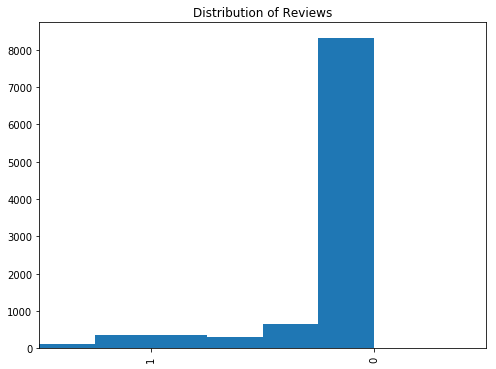

In [21]:
# Plot histogram of the polarity values
fig, ax = plt.subplots(figsize=(8, 6))
reviews2['compound'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1], ax=ax)
plt.title("Vader Sentiment");

# positive vs negative reviews counts
prob = reviews2["vader"].value_counts(normalize = True)
print(prob)
prob.plot(kind='bar')
plt.title('Distribution of Reviews');


For our purposes, we treat neutral as negative. 
Reviews are overwhelmingly positive. The sample is very imbalanced with ~6 % labeled as negative. This may  be a problem when creating a prediction model

### top words for positive and negative sentiment

In [22]:
import collections
from collections import Counter

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = STOPWORDS

def plotTopCommonWords(text, title):
   
    filtered_words = [word for word in text.split() if word not in stopwords]
    counted_words = collections.Counter(filtered_words)

    words = []
    counts = []
    for letter, count in counted_words.most_common(20):
        words.append(letter)
        counts.append(count)

    plt.figure(figsize=(10,8))    
    plt.title(title)
    plt.xlabel('Frequencies')
    plt.barh(words, counts)
    
# wordcloud function
# https://www.datacamp.com/community/tutorials/wordcloud-python
def show_wordcloud(data, title = None, maxwords=200):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words =  maxwords,
        stopwords = stopwords,
        max_font_size = 40, 
        #min_font_size=10,
        scale = 3
        #random_state = 42
    ).generate(str(data))

    wordcloud.to_file(title+'.png') # save
    fig = plt.figure(1, figsize = (15,15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    

### top postive reviews

,reviews.text
9734,The staff was so nice and helpful. The rooms w...
4316,Nice hotel friendly service would stay there a...
7113,Our room was clean and comfortable. The bed wa...
5199,"awesome place, we were gladly surprise, staff ..."
4388,The hotel was very nice.. will definitely stay...
924,Very modern and welcoming hotel. This will be ...
9530,Great location had a great time! recommend thi...
9642,Great Hotel. Clean and comfortable. Excellent ...
9529,Great location had a great time! recommend thi...
9661,the hotel was nice and clean the clerk jani wa...


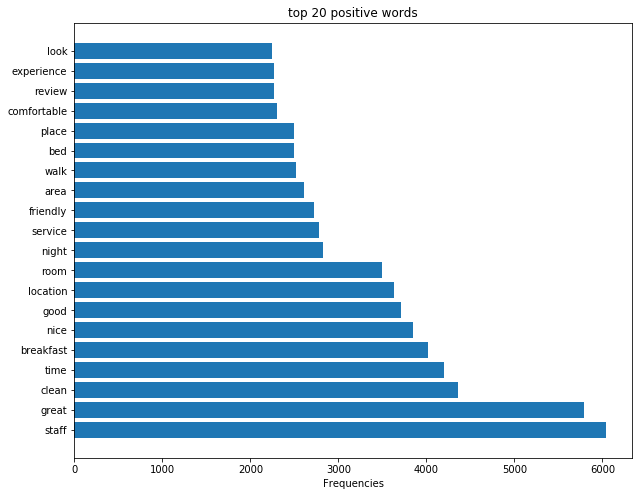

In [23]:
# top 20 words from positive sample
text = ' '.join(pos_reviews['review_clean']) 
plotTopCommonWords(text, 'top 20 positive words')

# top positive reviews with greater than 5 words
reviews2[reviews2["no_words"] >= 5].sort_values("pos",ascending=False)[["reviews.text"]].head(15)

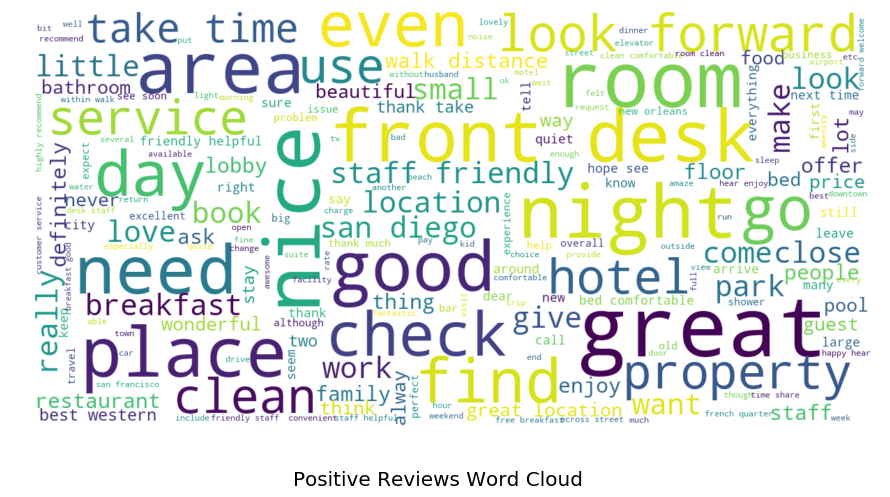

In [24]:
show_wordcloud(text,'Positive Reviews Word Cloud')


Top positive words/features and review text indicate staff, clean, time, breakfast and location as important concepts.

Word cloud confirms importance of staff/customer service, location, food options, cleanliness as well as room condition as most important features

### top negative reviews

,reviews.text
3636,The staff here is horrible and the manager suc...
1546,This is the worst hotel I have ever stayed in....
2269,The hotel is very rundown. I was very disappoi...
4095,Only complaint was a fire alarm test that wasn...
3293,We were price gouged on a Saturday night payin...
9,"Hello, I have traveled a lot and abroad and by..."
4984,Room was smelly and dark Bathroom was shocking...
6591,Very upset with my stay at this hotel. Room is...
7443,I canceled the stay after checking in. The roo...
8745,This hotel is horrible. Do not waste your mone...


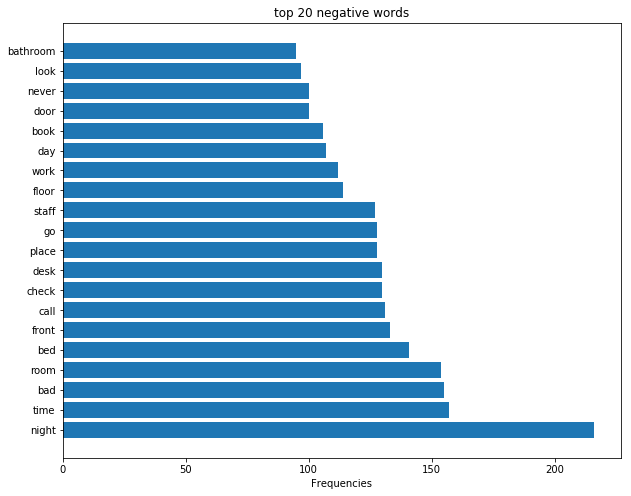

In [25]:
# top words/features for negative
text = ' '.join(neg_reviews['review_clean']) 
plotTopCommonWords(text, 'top 20 negative words')

#top 15 negative reviews
reviews2[reviews2["no_words"] >= 5].sort_values("neg",ascending=False)[["reviews.text"]].head(15)

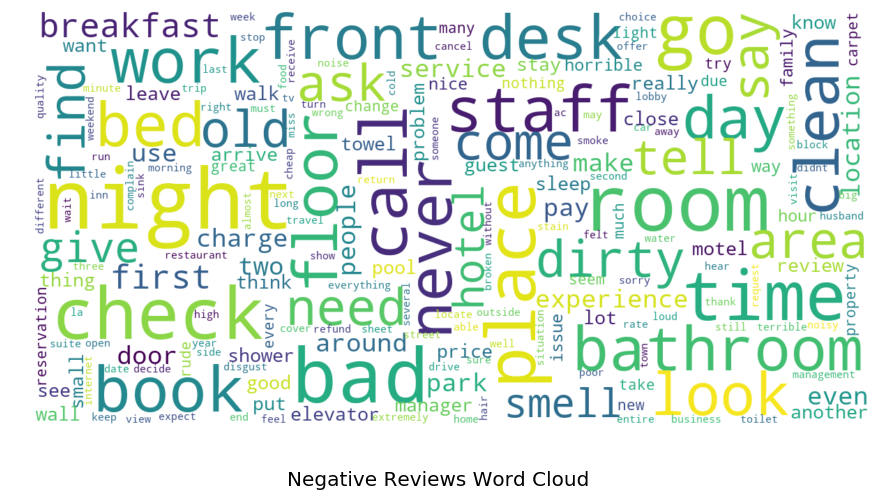

In [26]:
show_wordcloud(text, 'Negative Reviews Word Cloud',maxwords=200)


Top negative words: night, time, bad, room, bed.  Review text indicate issues with staff and cleanliness/condition of rooms.  It’s not immediately obvious what ‘time’ refers to. 

Word cloud show issues with cleanliness, rooms, staff.


## Text classification using supervised learning RandomForest

### Convert Text to Numbers using Term Frequency-Inverse Document Frequency

In [109]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


features = reviews2.review_clean # x
labels = reviews2.vader          # y


max_feat = 1500 # most x frequent words
#max_feat = None # whole corpus

tfidf = TfidfVectorizer (max_features = max_feat, 
                         min_df=5,  # min documents containing this feature
                         max_df=0.7, #include words occuring in a maximum of 70% of all documents
                         stop_words=stopwords.words('english'))

#Learn vocab and idf, return term-document matrix.
processed_features = tfidf.fit_transform(features).toarray() 


#print(tfidf.get_feature_names()) # x feature names
print('features:', processed_features.shape)
print(labels.value_counts())

pd.concat([features, labels], axis=1).head(5)

features: (10000, 1500)
1    9404
0     596
Name: vader, dtype: int64


,review_clean,vader
0,nice quiet know train track near train pass be...,1
1,king suite separation bedroom live space sofa ...,1
2,park horrible somebody run rental car stay bre...,0
3,cheap excellent location price somewhat standa...,1
4,advertised website pay may lucky.if many day g...,0


### Training and Testing Sets

In [110]:
from sklearn.ensemble import RandomForestClassifier

#  divides data into 20% test (2000) set and 80% training set (8000).
x_train, x_test, y_train, y_test = train_test_split(processed_features, 
                                                    labels, test_size=0.2, 
                                                    random_state=0)

print (len(processed_features))
print('x: ', len(x_train), len(x_test))
print('y: ', len(y_train), len(y_test))

10000
x:  8000 2000
y:  8000 2000


### Training Model and Predicting Sentiment

In [112]:
#regularization: utility to optimize n_estimators

#AUC (Area Under Curve) as the evaluation metric.
from sklearn.metrics import roc_curve, auc

n_estimators = [1, 2, 4, 8, 16, 32, 50, 100, 200]

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    
    train_pred = rf.predict(x_train)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc1 = auc(false_pos_rate, true_pos_rate)
    
    y_pred = rf.predict(x_test)
    false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc2 = auc(false_pos_rate, true_pos_rate)
    
    print('<%d> train auc: (%f)  test auc (%f)' %(estimator, roc_auc1,roc_auc2 ))

<1> train auc: (0.894174)  test auc (0.652101)
<2> train auc: (0.957799)  test auc (0.690938)
<4> train auc: (0.977070)  test auc (0.702204)
<8> train auc: (0.985427)  test auc (0.652618)
<16> train auc: (0.985626)  test auc (0.638765)
<32> train auc: (0.998973)  test auc (0.616093)
<50> train auc: (1.000000)  test auc (0.630912)
<100> train auc: (1.000000)  test auc (0.622267)
<200> train auc: (1.000000)  test auc (0.608505)


n_estimators=4 seems to be optimin for RandomForest?

In [113]:
estimators = 4
rfmodel = RandomForestClassifier(n_estimators=estimators, #number of trees in the foreset
                                 random_state=0, n_jobs=-1)

rfmodel.fit(x_train, y_train) # train

y_pred = rfmodel.predict(x_test) # predict


false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_pos_rate, true_pos_rate)
print ('AUC: ', roc_auc)

AUC:  0.7099636617682018


The area under the ROC curve ( AUC ) measures how well a parameter can distinguish between two groups.


In [114]:
len(rfmodel.feature_importances_)

1500

In [115]:
#Evaluating the Model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def plotConfMat(mat):
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')

# manual calculations
def printRecallPrec(true_pos0, false_neg0, true_pos1, false_neg1) :
    #recall = true_pos / (true_pos + false_neg)
    #cls0_recall = 57/(57+52)
    #cls1_recall = 1724/(1724+167)
    cls0_recall = true_pos0 / (true_pos0 + false_neg0)
    cls0_recall = true_pos1 / (true_pos1 + false_neg1)

    #precision = true_pos / (true_pos + false_pos)
    #cls0_prec = 57/(57+167)
    #cls1_prec = 1724/(1724+52)
    cls0_prec = true_pos0 / (true_pos0 + false_pos0)
    cls1_prec = true_pos1 / (true_pos1 + false_pos1)

    # f1-score = 2 * (precision * recall) / (precision + recall)
    cls0_fl = 2* (cls0_prec*cls0_recall)/(cls0_prec + cls0_recall)
    cls1_f1 = 2* (cls1_prec*cls1_recall)/(cls1_prec + cls1_recall)

    print('class\t recall\t prec\t f1-score')
    print('%d\t %.2f\t %.2f\t %.2f'%(0, cls0_recall, cls0_prec, cls0_fl))
    print('%d\t %.2f\t %.2f\t %.2f'%(1, cls1_recall, cls1_prec, cls1_f1))


In [118]:
print('Accuracy: ', accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('\nConfusion matrix\n', conf_matrix)
#plotConfMat(conf_matrix)

# how many classes is it predicting
print('\nclasses predicted:', np.unique( y_pred ) )

print(classification_report(y_test, y_pred))

Accuracy:  0.942

Confusion matrix
 [[  49   60]
 [  56 1835]]

classes predicted: [0 1]
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       109
           1       0.97      0.97      0.97      1891

    accuracy                           0.94      2000
   macro avg       0.72      0.71      0.71      2000
weighted avg       0.94      0.94      0.94      2000



negative (class 0): 49 classified correctly while 60 incorrectly and f1-score of 46%<br>
positive (class 1): 56 incorrectly classified while 1835 correctly and f1-scorre of 97%<br>

Classification performance is excellent for positive reviews, but poor for negative reviews.

Micro-average of 89% is preferable due to class imbalance.  
Macro-average is lower than micro-average in cases with class imbalance.

In [119]:
# test with unseen data
def testNewData():
    corpus = ['Dirty room and uncomfortable bed.', 
              'Loved my hotel stay', 
              'Workers so nice and took care of our every need.',
              'Slept horribly because of loud noises all night.',
              'good location, near all attractions.',
              'comfortable bed, had the best sleep.',
              'best sleep of my life',]

    #print(corpus)
    pred = rfmodel.predict(tfidf.transform(corpus))

    df1 = pd.DataFrame(corpus, columns =['text']) 
    df2 = pd.DataFrame(pred, columns =['predict class']) 
    return pd.concat([df1, df2],  axis=1)
    
    
df=testNewData()
df

,text,predict class
0,Dirty room and uncomfortable bed.,0
1,Loved my hotel stay,1
2,Workers so nice and took care of our every need.,1
3,Slept horribly because of loud noises all night.,0
4,"good location, near all attractions.",1
5,"comfortable bed, had the best sleep.",1
6,best sleep of my life,0


Record # 6 was misclassified as negative

### Synthetic Minority Oversampling Technique (SMOTE)

Synthetic Minority Oversampling Technique (SMOTE) is an oversampling technique used in an imbalanced dataset problem

In [120]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

#print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
#print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 7513
Before OverSampling, counts of label '0': 487 

After OverSampling, counts of label '1': 7513
After OverSampling, counts of label '0': 7513


In [121]:
rfmodel.fit(x_train_res, y_train_res.ravel()) # train

y_pre = rfmodel.predict(x_test) # predict

In [122]:
print('Accuracy: ', accuracy_score(y_test, y_pre))

conf_matrix = confusion_matrix(y_test, y_pre)
print('\nConfusion matrix\n', conf_matrix)

print(classification_report(y_test, y_pre))

Accuracy:  0.9235

Confusion matrix
 [[  56   53]
 [ 100 1791]]
              precision    recall  f1-score   support

           0       0.36      0.51      0.42       109
           1       0.97      0.95      0.96      1891

    accuracy                           0.92      2000
   macro avg       0.67      0.73      0.69      2000
weighted avg       0.94      0.92      0.93      2000



In [123]:
# test with unseen data
testNewData()

,text,predict class
0,Dirty room and uncomfortable bed.,0
1,Loved my hotel stay,0
2,Workers so nice and took care of our every need.,1
3,Slept horribly because of loud noises all night.,0
4,"good location, near all attractions.",0
5,"comfortable bed, had the best sleep.",1
6,best sleep of my life,1


References:<br>
https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products<br>
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184 <br>
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d <br>
https://stackabuse.com/text-classification-with-python-and-scikit-learn/ <br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br>
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets<br>

